## Titanic Exploratory Data Analysis: 
In this document, we will analyze the Titanic Dataset to gain insights into the distribution of variables, explore their relationships, and identify the key factors that are important for creating a predictive model. Our analysis will involve exploring the distribution of variables, identifying correlations or dependencies between them, and determining which variables have significant predictive power. This EDA process will serve as the foundation for feature selection, data preprocessing, and model development in subsequent stages.

In [38]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re 
import os

In [39]:
train_path = os.path.join("Data", "train.csv")
test_path = os.path.join("Data", "test.csv")

In [40]:
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

# Initial Visualization of Data:
For starters we are going to analyze the data structure of the dataset, we are going to see how much null valued rows we have and if any features need any type of treatment due to missing data. 

In [41]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB



<ul>
  <li>
    The <strong>cabin</strong> feature given in the dataset has approximately 600 rows with missing values. This means that nearly 80% of all rows in this feature are missing.
  </li>
  <li>
    <strong>Age</strong> has 177 rows with missing values, which constitutes approximately 21% of the rows.
  </li>
  <li>
    The <strong>Embarked</strong> feature is missing in 2 rows, which means that 0.22% of the rows are missing in the dataset.
  </li>
</ul>

Throughout this Jupyter notebook, we will handle these missing data so that they do not affect the prediction model.

In [42]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Important Initial Questions: 
Some important Questions we want to ask ourselfs about the data are the following: 
1. Are Lonely passengers prone to survival during the Titanic incident?
2. Is Marriage an important feature to take into account?
3. How is Survival rates distributed between Ages? and between Adults and children?
4. What features are more correlated to survival?

As you can see here, the data of Ticket, Name, Sex, Cabin, Embarked are all in string format. This can pose challenges for models to interpret the data accurately. To address this, we will perform data analysis and transformation to convert these features into numerical format.

# Name Feature Engineering:
First, let's focus on the name feature. In this dataset, the names follow a specific structure. The last name of the person is given first, followed by the title, and finally, the first name. In some cases, there are parentheses in the names, indicating the maiden name for married women. The name column contains abundant information about the people on the Titanic. To structure this information, here is a summary of the name components:

<ol>
  <li>
    <strong>Last Name</strong>: This represents the surname or last name of the passenger, which comes first in the name structure.
  </li>
  <li>
    <strong>Title</strong>: The title component includes honorific titles such as Mr., Mrs., Miss., Master., etc. These titles provide information about the gender and marital status of the passenger.
  </li>
  <li>
    <strong>First Name</strong>: This is the given name or first name of the passenger, which appears after the title. For example, "John" or "Mary".
  </li>
  <li>
    <strong>Maiden Name</strong>: For married women, the maiden name may be included in parentheses after the first name. It indicates the woman's family name before marriage.
  </li>
</ol>
Based on this analysis, we will generate the following features from the name:

<ol>
  <li>
    <strong>familyId</strong>: This feature will provide the last name of the passenger and their ticket number. It will serve as a family identifier, as tickets for family members are the same.
  </li>
  <li>
    <strong>isMarried</strong>: This column will indicate whether the passenger was married or not. For women, this feature can be determined directly from the presence of parentheses in the name, indicating marriage.
  </li>
  <li>
    <strong>isAdult</strong>: This column will indicate whether the passenger was an adult or a child. It can be determined from the name's title, such as Mr. or Mrs. for adults and Master or Miss for children.
  </li>
</ol>
Please note that these features will help us extract valuable information from the name column and represent it in a structured numerical format.

In [43]:
# generate new column called LastName:
train_df["familyId"] = train_df.apply(lambda x: str((x["Name"].split(",")[0], x["Ticket"])), axis=1)

In [44]:
def get_pattern(x, pattern="(?<= )[A-Za-z]*(?=[)])", default_attr="marriedLastName", default_value=None, boolean=False): 
    search = re.search(pattern, x["Name"])
    if default_value is None and default_attr is None: 
        raise ValueError("Both Default values are None, you must at least provide one.")
    if search: 
        returned_pattern =  search.group(0)
        if boolean: 
            return 1
        else: 
            return returned_pattern
    else: 
        if boolean: 
            return 0
        else: 
            if default_attr: 
                return getattr(x, default_attr)
            else: 
                return default_value
# train_df["singleLastName"] = train_df.apply(lambda x: single_last_name(x), axis=1)

In [45]:
train_df["isAdult"] = train_df.apply(lambda x: int(get_pattern(x, pattern="(?<= )Mr|Mrs|Dr|Rev|Sir(?=[.])", boolean=True) or x["Age"]>=18), axis=1)

In [46]:
train_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,familyId,isAdult
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,"('Braund', 'A/5 21171')",1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,"('Cumings', 'PC 17599')",1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,"('Heikkinen', 'STON/O2. 3101282')",1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,"('Futrelle', '113803')",1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,"('Allen', '373450')",1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,"('Montvila', '211536')",1
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,"('Graham', '112053')",1
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S,"('Johnston', 'W./C. 6607')",0
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C,"('Behr', '111369')",1


In [47]:
train_df["isMarried"] = train_df.apply(lambda x: int("(" in x["Name"]) if x["Sex"] =="female" else 0, axis=1)

As we can see the new dataframe lets us use the Name attribute in order to get if the person is married or not (just for women) and lets us know the family relationships between Passengers due to its LastName. 

In [48]:
train_df[train_df["Sex"]=="female"]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,familyId,isAdult,isMarried
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,"('Cumings', 'PC 17599')",1,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,"('Heikkinen', 'STON/O2. 3101282')",1,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,"('Futrelle', '113803')",1,1
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S,"('Johnson', '347742')",1,1
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C,"('Nasser', '237736')",1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
880,881,1,2,"Shelley, Mrs. William (Imanita Parrish Hall)",female,25.0,0,1,230433,26.0000,NaN,S,"('Shelley', '230433')",1,1
882,883,0,3,"Dahlberg, Miss. Gerda Ulrika",female,22.0,0,0,7552,10.5167,NaN,S,"('Dahlberg', '7552')",1,0
885,886,0,3,"Rice, Mrs. William (Margaret Norton)",female,39.0,0,5,382652,29.1250,NaN,Q,"('Rice', '382652')",1,1
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,"('Graham', '112053')",1,0


Now we will fix the married column for men, in order to do this we will look for the family name and check if there are two adults and check if the female adult is married, in that case the man is also married, in cases where the wife is not in the ship we cannot tell directly if the man was in fact married. 

In [49]:
# groupping by the family name: 
LastNameGroups = train_df.groupby(["familyId"])

In [50]:
def is_this_man_married(passenger, grouped_families_list):
    grouped_families_list =grouped_families_list[grouped_families_list["PassengerId"]!=passenger["PassengerId"]]
    has_wife = np.logical_and(grouped_families_list["isAdult"],\
                             (grouped_families_list["Sex"]=="female"),
                            grouped_families_list["isMarried"])
    justSp = passenger["SibSp"]==1
    return any(has_wife)*justSp

In [51]:
married_candidates = train_df[(train_df["Sex"]=="male") & (train_df["isAdult"])]

In [52]:
married_candidates.familyId

0               ('Braund', 'A/5 21171')
4                   ('Allen', '373450')
5                   ('Moran', '330877')
6                 ('McCarthy', '17463')
12         ('Saundercock', 'A/5. 2151')
                     ...               
883    ('Banfield', 'C.A./SOTON 34068')
884     ('Sutehall', 'SOTON/OQ 392076')
886              ('Montvila', '211536')
889                  ('Behr', '111369')
890                ('Dooley', '370376')
Name: familyId, Length: 537, dtype: object

In [53]:
are_married = married_candidates.apply(lambda x: is_this_man_married(x, train_df.iloc[list(LastNameGroups.groups[x["familyId"]])]),axis=1)

In [54]:
train_df.loc[married_candidates.index, "isMarried"]= are_married

# Managing Age:
From the previous analysis, we discovered that determining if passengers were married or not is important for our predictions. Additionally, using age alone as an indicator of priority during the Titanic sinking is not sufficient, as a very young person could still be a parent or married. The conventional definition of ">18" and "<18" as indicators of youth is based on cultural norms that may not align with the time when the Titanic sank. Therefore, to handle the missing values in the Titanic dataset, we will fill them with the mean value, taking into account whether the passenger was an adult or not.

In [55]:
adult_age_mean = train_df[train_df["isAdult"]==1]["Age"].mean()
children_age_mean = train_df[train_df["isAdult"]==0]["Age"].mean()
train_df.loc[(train_df["isAdult"]==1) & (train_df["Age"].isna()), "Age"]= adult_age_mean
train_df.loc[(train_df["isAdult"]==0) & (train_df["Age"].isna()), "Age"] = children_age_mean

# Handling Cabin Missing Data: 
As Cabin feature is missing on approximately 80% of the rows, in order to address this issue we will drop the feature in order to feed our model with data that most probably will be in the given information.

In [56]:
train_df.drop(columns=["Cabin"], inplace=True)

## Handling Embarked_missing Data:
As the Embarked variable has only 0.22% value of the whole dataset missing we will drop those rows in order to have only existent embarked features. 

In [57]:
embarked_index = train_df[train_df["Embarked"].isna()].index
train_df.drop(index= embarked_index, inplace=True)

# Feature Engineering:  
To enrich our model, we want to add some extra features that can help it make better predictions. We'll include two new features: "family Size," which tells us how many family members a person had onboard, and "isAlone," which tells us if they were traveling alone or with others. These features will provide important information for the model to consider when making its predictions.

In [58]:
# setting the family Size
train_df["familySize"] = train_df.apply(lambda x: x["SibSp"]+x["Parch"]+1, axis=1)
# setting the isAlone: 
train_df["isAlone"] = train_df.apply(lambda x: int(x["familySize"]==1), axis=1)

In [59]:
train_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,familyId,isAdult,isMarried,familySize,isAlone
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000000,1,0,A/5 21171,7.2500,S,"('Braund', 'A/5 21171')",1,0,2,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000000,1,0,PC 17599,71.2833,C,"('Cumings', 'PC 17599')",1,1,2,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000000,0,0,STON/O2. 3101282,7.9250,S,"('Heikkinen', 'STON/O2. 3101282')",1,0,1,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000000,1,0,113803,53.1000,S,"('Futrelle', '113803')",1,1,2,0
4,5,0,3,"Allen, Mr. William Henry",male,35.000000,0,0,373450,8.0500,S,"('Allen', '373450')",1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.000000,0,0,211536,13.0000,S,"('Montvila', '211536')",1,0,1,1
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.000000,0,0,112053,30.0000,S,"('Graham', '112053')",1,0,1,1
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,7.007701,1,2,W./C. 6607,23.4500,S,"('Johnston', 'W./C. 6607')",0,0,4,0
889,890,1,1,"Behr, Mr. Karl Howell",male,26.000000,0,0,111369,30.0000,C,"('Behr', '111369')",1,0,1,1


# Transform Strings to Categorical:

To ensure that we only have numerical features for this dataset, certain string variables need to be transformed into categorical values, while other columns will be dropped from the dataset. Specifically, we will transform the "Sex" and "Embarked" columns into categorical values, which will later aid in identifying the most suitable features for model development. Additionally, we will drop the following columns from the dataset: "familyId" (as it has already served its purpose), "Name" (since we have already extracted all the necessary information from it), and "Ticket" (for the same reason as "familyId"). Although one could argue that knowing the family could provide valuable insights, the important information has already been captured through variables such as marriage, family size, isAdult, and isAlone. By focusing on these features, we can uncover the general patterns present in the data.

In [60]:
train_df["Embarked"].unique()

array(['S', 'C', 'Q'], dtype=object)

In [61]:
from sklearn import preprocessing

Embarked_label_encoder = preprocessing.LabelEncoder()
Embarked_label_encoder.fit(["C", "Q", "S"])
train_df["Embarked"] = Embarked_label_encoder.transform(train_df["Embarked"])

In [62]:
from sklearn import preprocessing
sex_label_binarizer = preprocessing.LabelEncoder()
sex_label_binarizer.fit(["male", "female"])
train_df["Sex"] = sex_label_binarizer.transform(train_df["Sex"])

In [63]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,familyId,isAdult,isMarried,familySize,isAlone
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,2,"('Braund', 'A/5 21171')",1,0,2,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,0,"('Cumings', 'PC 17599')",1,1,2,0
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,2,"('Heikkinen', 'STON/O2. 3101282')",1,0,1,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,2,"('Futrelle', '113803')",1,1,2,0
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,2,"('Allen', '373450')",1,0,1,1


## dropping un needed data:  


In [69]:
train_df.drop(columns=["Name", "familyId", "Ticket"], inplace=True)

In [70]:
train_df.set_index("PassengerId", inplace=True)

In [71]:
def plot_correlation_matrix(df):
    corr_matrix = df.corr()
    labels = df.columns
    # generate the upper triangle mask:
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    # generate the figure
    fig, ax = plt.subplots(figsize=(11,9))
    # set the colors
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    # generamos el mapa de calor con la matriz de correlacion
    sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5}, xticklabels=labels, yticklabels=labels)
    ax.set_title("Label Correlation Matrix")

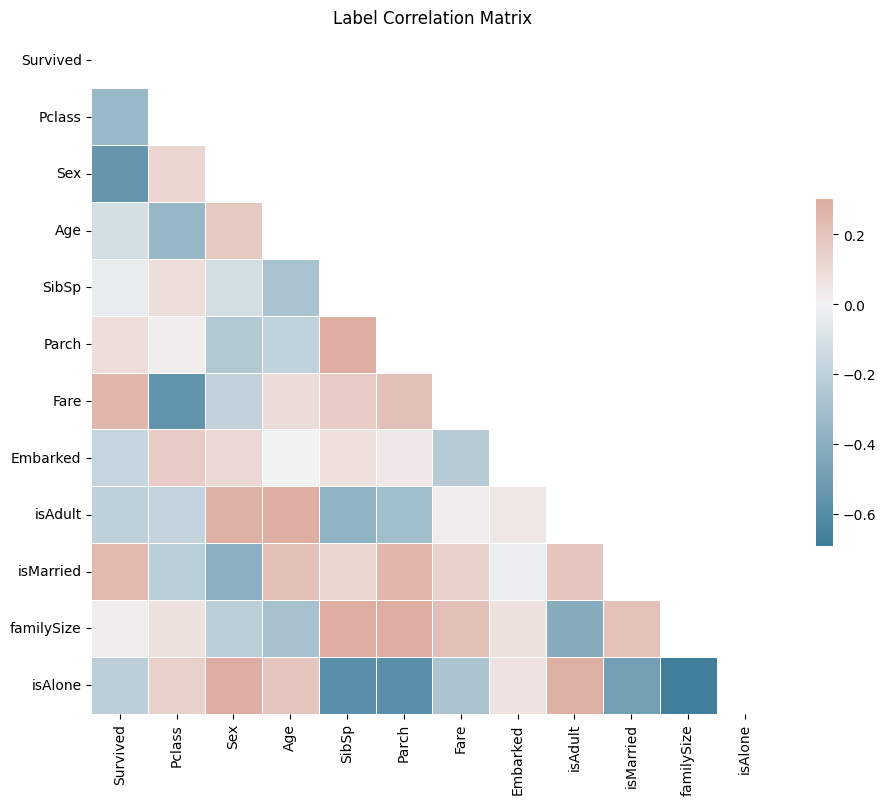

In [72]:
plot_correlation_matrix(train_df)

In this plot, we observe a strong inverse correlation between sex and survival, indicating that gender played a significant role in the rescue efforts during the Titanic tragedy, aligning with historical records. Additionally, there is a correlation between marital status and survival, suggesting that being married may have influenced the chances of survival. Lastly, the passenger class (Pclass) exhibits a negative correlation with survival, indicating that individuals in higher classes had a higher likelihood of being saved.

# Adult Survival vs Children survival by sex: 

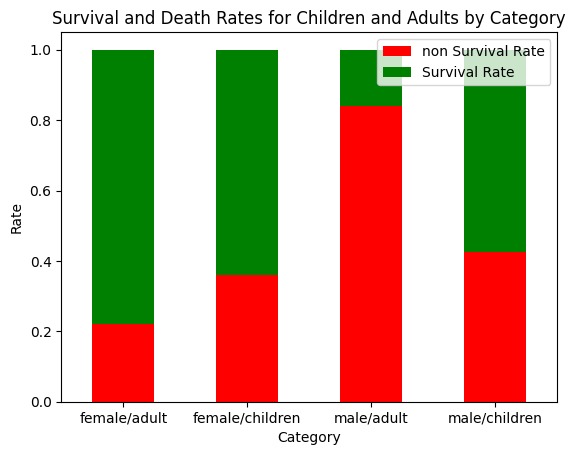

In [73]:
# Subset the dataframe
subset_df = train_df[['Survived', 'Sex', 'isAdult']].copy()


# Create a new column to represent the combined category of Sex and Age
subset_df['Category'] = subset_df.apply(lambda row: 'male/children' if (row['Sex'] == 1 and row['isAdult']==0)
                                          else 'female/children' if (row['Sex'] == 0 and row['isAdult']==0)
                                          else 'male/adult' if (row['Sex'] ==1 and row['isAdult']==1)
                                          else 'female/adult', axis=1)

# Group the data and calculate survival and death rates
grouped_data = subset_df.groupby('Category')['Survived'].value_counts(normalize=True).unstack()

# Plot the stacked bar chart
colors = ['red', 'green']
grouped_data.plot(kind='bar', stacked=True, color=colors)

# Customize the plot
plt.xlabel('Category')
plt.ylabel('Rate')
plt.title('Survival and Death Rates for Children and Adults by Category')
plt.xticks(rotation=0)
plt.legend(['non Survival Rate', 'Survival Rate'])

# Show the plot
plt.show()

This particular plot provides intriguing insights. It reveals that the female/adult population aboard the Titanic had the highest survival rate, surpassing even the survival rate of children. This observation could be attributed to two potential factors. Firstly, adult women may have prioritized the safety of their children, leading to a higher likelihood of survival. Secondly, the physical resilience and experience of adults might have played a role, as their bodies are generally more resistant to injuries.

Furthermore, a striking revelation from the plot is that approximately 80% of adult men perished in the Titanic tragedy. This statistic demonstrates the lack of preparedness of the Titanic.

Interestingly, the survival rates of male children and female children are quite similar, indicating that gender played a less significant role in the fate of children compared to adults.

# Coordinate Plot: 
In order to analyze if there are any patterns in data we are going to normalize the data in another dataframe so we can see how data patterns distribute. 

In [74]:
normalized_data = train_df.copy()
standard_scaler = preprocessing.MinMaxScaler()
standard_scaler.fit(train_df)
normalized_data = pd.DataFrame(standard_scaler.transform(train_df), columns=train_df.columns, index=train_df.index)


In [75]:
normalized_data["Survived"] = train_df["Survived"]

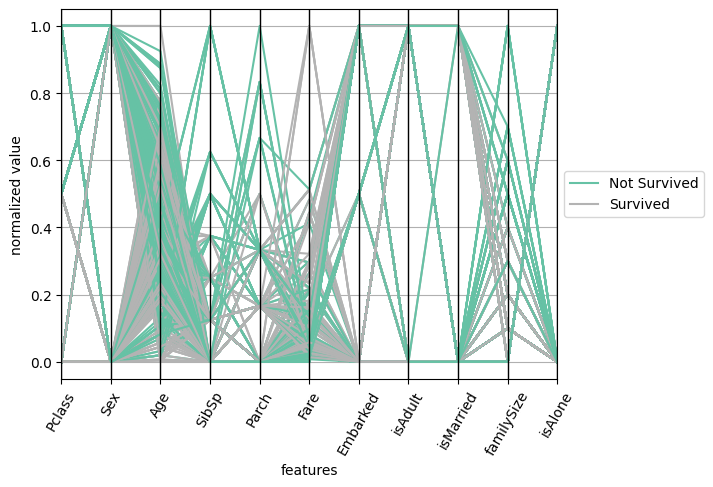

In [81]:
from pandas.plotting import parallel_coordinates

parallel_coordinates(normalized_data, 'Survived', colormap=plt.get_cmap("Set2"))
plt.xticks(rotation=60)
plt.xlabel("features")
plt.ylabel("normalized value")
plt.legend(["Not Survived", "Survived"], loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


In this plot, we are analyzing the relationships between different features to identify any trends or patterns. One interesting observation is the correlation between Sex and Age, where we can clearly see that male passengers who did not survive outnumbered the survivors, while most female passengers survived.

Additionally, when examining the columns isMarried and familySize, we can observe that the majority of the survivors were married individuals with smaller family sizes. Conversely, the passengers who did not survive were mostly unmarried and had larger family sizes.

These patterns provide valuable insights into the factors that influenced survival rates among the Titanic passengers.

# Survived and not Survived Distribution: 


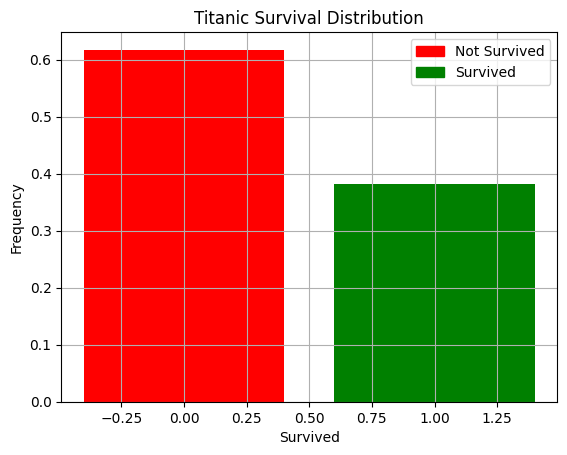

In [93]:
colors = ["red", "green"]
label_counts = train_df["Survived"].value_counts()

plt.bar(label_counts.index, label_counts.values/len(train_df), color=colors)
plt.xlabel("Survived")
plt.ylabel("Frequency")
plt.title("Titanic Survival Distribution")
plt.grid()

legend_labels = ["Not Survived", "Survived"]
legend_handles = [plt.Rectangle((0, 0), 1, 1, color=color) for color in colors]
plt.legend(legend_handles, legend_labels)

plt.show()


In this plot, we can observe that the data is relatively balanced. Approximately 60% of the data represents the "Not Survived" category, while around 38% of the data corresponds to the "Survived" category. This balanced distribution is advantageous as it eliminates the need for additional techniques to address class imbalance in the dataset.